In [1]:
import numpy as np
import scipy as sp
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from multiprocess import Pool, cpu_count

# Case I - Bar do Adriano

Com um fim (?) da pandemia, o **Bar do Adriano** está fazendo muito sucesso. O seu dono, Adriano, está preocupado com as **filas que estão se formando fora do bar**, e com a **perda de clientes** (muitos desistem de esperar na fila).

O bar é *bem simples*, contendo apenas um **balcão com 10 lugares**. Devido as leis de zoneamento da região, Adriano não pode instalar mesas fora do bar, e, portanto, está buscando alternativas. No entanto ele **teme que o aumento no número de clientes não seja suficiente para balancear o aumento de custo operacional e investimento necessário para expansão do balcão**.

**Você foi contrado para estimar quantos clientes diferentes tamanhos de balcão poderiam atender**! Infelizmente, **Adriano não possui NENHUM dado sobre a operação de seu bar**, apenas algumas medições simples:

1. *O bar fica aberto 3h por noite (vizinhos chatos...)*;
1. *Em média, 50 clientes entram na fila por hora*;
1. *Em média, um cliente fica 15m na fila antes de desistir*;
1. *Uma vez sentados, clientes ficam, em média, 30m no balcão*;
1. *O bar atualmente tem 10 bancos mas Adriano tem a possibilidade de investir e aumentar este número para 30*.

**Conhecendo os rudimentos da Probabilidade, você decide utilizar simulação de Monte Carlo para construir esta estimativa!**

In [31]:
MEDIA_CHEGADA = 50/60 # Clientes/Minuto
NUM_MINUTOS = 180
rv_chegada = sp.stats.poisson(MEDIA_CHEGADA)

simulacao_monte_carlo = []
for j in range(50):
    clientes_chegando = []
    for i in range(NUM_MINUTOS):
        clientes_chegando.append(rv_chegada.rvs())
    simulacao_monte_carlo.append(clientes_chegando)

In [42]:
MEDIA_CHEGADA = 50/60 # Clientes/Minuto
NUM_MINUTOS = 180
rv_chegada = sp.stats.poisson(MEDIA_CHEGADA)

simulacao_monte_carlo = []
for i in range(500):
    num_clientes_noite = 0
    for minuto in range(NUM_MINUTOS):
        num_clientes_noite += rv_chegada.rvs()
    simulacao_monte_carlo.append(num_clientes_noite)
    
plt.hist(simulacao_monte_carlo)

In [50]:
MEDIA_CHEGADA * NUM_MINUTOS * GASTO_MEDIO

7500.0

In [51]:
MEDIA_CHEGADA = 50/60 # Clientes/Minuto
NUM_MINUTOS = 180
GASTO_MEDIO = 50
GASTO_SD = 5
rv_chegada = sp.stats.poisson(MEDIA_CHEGADA)
rv_gasto = sp.stats.norm(loc = GASTO_MEDIO, scale = GASTO_SD)

simulacao_monte_carlo = []
for i in range(500):
    gasto_total = 0
    for minuto in range(NUM_MINUTOS):
        num_clientes_minuto = rv_chegada.rvs()
        for cliente in range(num_clientes_minuto):
            gasto_total += rv_gasto.rvs()
    simulacao_monte_carlo.append(gasto_total)

In [52]:
np.quantile(simulacao_monte_carlo, q= [0.05, 0.25, 0.5, 0.75, 0.95])

array([6518.54553216, 7055.67740572, 7543.17971765, 7954.41165391,
       8565.83509926])

## Case Completo

In [2]:
# Parâmetros Observáveis (medido)
NUM_MINUTOS = 180 # Minutos
MEDIA_CHEGADA = 50/60 # Clientes/Minuto
TEMPO_DESISTE = 15 # Minutos
TEMPO_ESTADIA = 30 # Minutos
TAMANHO_BALCAO = 10 # Número de Cadeiras
# Distribuição Geométrica
# Número de lances até primeira cara
# Qual a probabilidade de você jogar X moedas antes de tirar uma cara.
# Cada lance é um minuto do clienta na fila
# Média de Minutos = 1 / probabilidade do cliente desistir
# probabilidade = 1 / Média de Minutos
p_desiste_minuto = 1/TEMPO_DESISTE

# Variáveis Aleatórias
# Número de clientes chegando no bar (R.V. média = 50/60)
# Tempo balcao (R.V. média = 30m)
# Abandono de file (R.V., teste bernoulli, com p = 1/15)
rv_chegada = sp.stats.poisson(MEDIA_CHEGADA)
rv_tempo_balcao = sp.stats.expon(TEMPO_ESTADIA)
rv_abandono = sp.stats.bernoulli(p_desiste_minuto)

# Estados
balcao_bar = []
fila = []

# Observaveis
n_cliente = 0
n_abandono = 0
n_cliente_atendido = 0
tx_ocup = []

In [ ]:
for i in range(NUM_MINUTOS):
    # MODELANDO CHEGADA DE CLIENTES
    num_clientes = rv_chegada.rvs()
    if num_clientes > 0:
        for cliente in range(num_clientes):
            n_cliente += 1
            tempo_estadia = int(rv_tempo_balcao.rvs())
            minuto_saida = i + tempo_estadia
            fila.append((n_cliente, i, minuto_saida))

    # MODELANDO CLIENTES SAINDO DA FILA P/ BALCAO
    while len(balcao_bar) < TAMANHO_BALCAO and len(fila) > 0:
        cliente_atendido = fila.pop(0)
        balcao_bar.append(cliente_atendido)
        
    # MODELANDO SAIDA DE CLIENTES DO BALCAO
    if len(balcao_bar) > 0:
        lista_saida = []
        for cliente in balcao_bar:
            if i >= cliente[2]:
                lista_saida.append(cliente)
        for cliente in lista_saida:
            n_cliente_atendido += 1
            balcao_bar.pop(balcao_bar.index(cliente))

    # MODELANDO DESISTENCIA DA FILA
    if len(fila) > 0:
        lista_desiste = []
        for cliente in fila:
            if rv_abandono.rvs() == 1:
                lista_desiste.append(cliente)
        for cliente in lista_desiste:
            n_abandono += 1
            fila.pop(fila.index(cliente))

    tx_ocup.append(len(balcao_bar)/TAMANHO_BALCAO)


In [53]:
def simular_bar(tam_balcao):
    NUM_MINUTOS = 180
    MEDIA_CHEGADA = 50/60
    TEMPO_DESISTE = 15
    TEMPO_ESTADIA = 30
    TAMANHO_BALCAO = tam_balcao

    balcao_bar = []
    fila = []
    p_desiste_minuto = 1/TEMPO_DESISTE

    rv_chegada = sp.stats.poisson(MEDIA_CHEGADA)
    rv_tempo_balcao = sp.stats.expon(TEMPO_ESTADIA)
    rv_abandono = sp.stats.bernoulli(p_desiste_minuto)

    n_cliente = 0
    n_abandono = 0
    n_cliente_atendido = 0
    tx_ocup = []
    for i in range(NUM_MINUTOS):
        # MODELANDO CHEGADA DE CLIENTES
        num_clientes = rv_chegada.rvs()
        if num_clientes > 0:
            for cliente in range(num_clientes):
                n_cliente += 1
                tempo_estadia = int(rv_tempo_balcao.rvs())
                minuto_saida = i + tempo_estadia
                fila.append((n_cliente, i, minuto_saida))

        # MODELANDO CLIENTES SAINDO DA FILA P/ BALCAO
        while len(balcao_bar) < TAMANHO_BALCAO and len(fila) > 0:
            cliente_atendido = fila.pop(0)
            balcao_bar.append(cliente_atendido)
            
        # MODELANDO SAIDA DE CLIENTES DO BALCAO
        if len(balcao_bar) > 0:
            lista_saida = []
            for cliente in balcao_bar:
                if i >= cliente[2]:
                    lista_saida.append(cliente)
            for cliente in lista_saida:
                n_cliente_atendido += 1
                balcao_bar.pop(balcao_bar.index(cliente))

        # MODELANDO DESISTENCIA DA FILA
        if len(fila) > 0:
            lista_desiste = []
            for cliente in fila:
                if rv_abandono.rvs() == 1:
                    lista_desiste.append(cliente)
            for cliente in lista_desiste:
                n_abandono += 1
                fila.pop(fila.index(cliente))

        tx_ocup.append(len(balcao_bar)/TAMANHO_BALCAO)
        
    return (n_cliente, n_cliente_atendido, n_abandono, np.mean(tx_ocup), tam_balcao)

In [54]:
lista_resultados = []
for it in range(500):
    lista_resultados.append(simular_bar(10))



In [55]:
tb_resultados = pd.DataFrame(lista_resultados, columns = ['n_clientes', 'n_atendido', 'n_abandono', 'tx_ocup', 'tam_balcao'])
tb_resultados.head()

,n_clientes,n_atendido,n_abandono,tx_ocup,tam_balcao
0,160,78,68,0.936667,10
1,145,70,60,0.915556,10
2,145,68,64,0.930000,10
3,157,68,73,0.931667,10
4,164,77,76,0.943333,10


<AxesSubplot: ylabel='tx_ocup'>

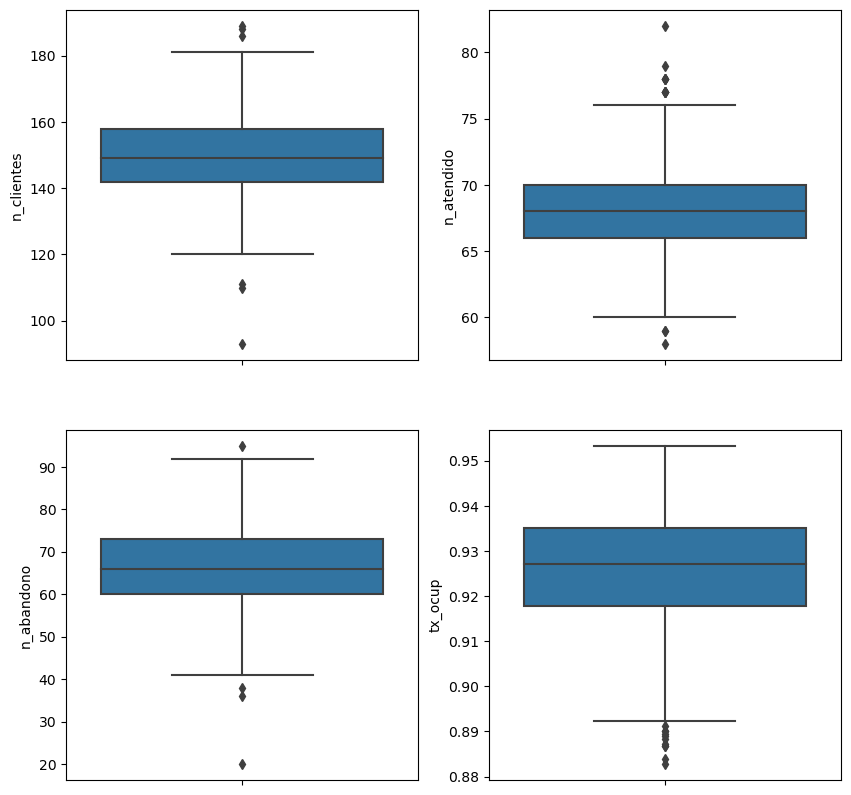

In [56]:
fig, ax = plt.subplots(2, 2, figsize=(10,10))
sns.boxplot(data = tb_resultados, y = 'n_clientes', ax = ax[0][0])
sns.boxplot(data = tb_resultados, y = 'n_atendido', ax = ax[0][1])
sns.boxplot(data = tb_resultados, y = 'n_abandono', ax = ax[1][0])
sns.boxplot(data = tb_resultados, y = 'tx_ocup', ax = ax[1][1])


In [64]:
pool = Pool(processes=cpu_count() - 1)
lista_balcoes = [10] * 100 + [15] * 100 + [20] * 100 + [25] * 100 + [30] * 100
lista_resultados = pool.map(simular_bar, lista_balcoes)

In [65]:
tb_resultados = pd.DataFrame(lista_resultados, columns = ['n_clientes', 'n_atendido', 'n_abandono', 'tx_ocup', 'tam_balcao'])
tb_resultados.tail()

,n_clientes,n_atendido,n_abandono,tx_ocup,tam_balcao
495,148,121,2,0.758333,30
496,161,124,9,0.769815,30
497,130,101,3,0.650741,30
498,124,106,0,0.658704,30
499,127,102,0,0.661481,30


<AxesSubplot: xlabel='tam_balcao', ylabel='tx_ocup'>

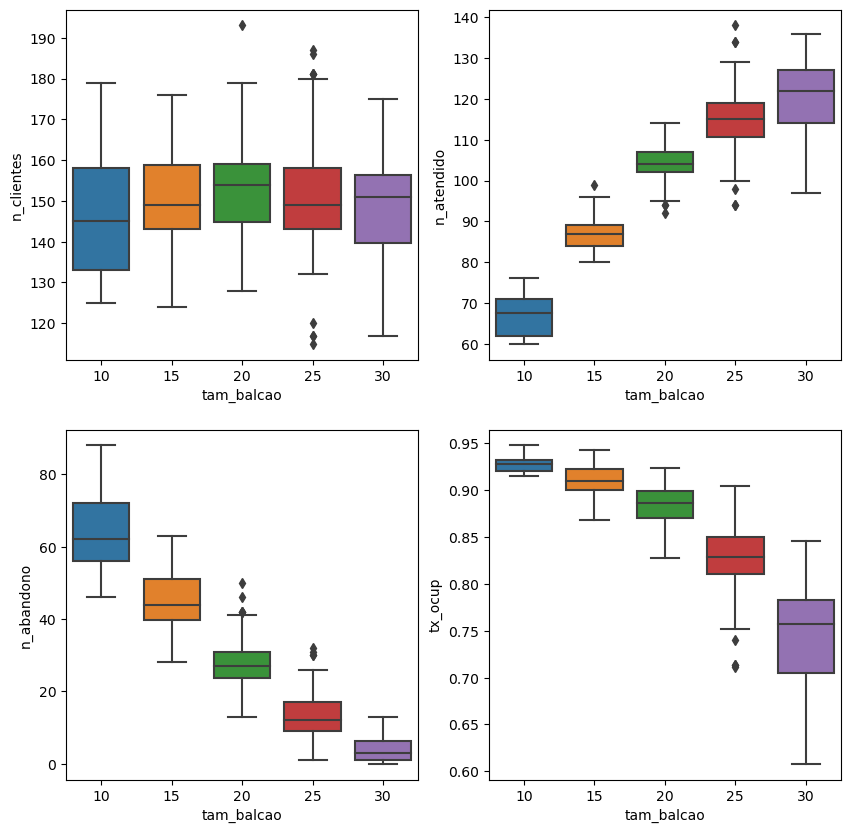

In [66]:
fig, ax = plt.subplots(2, 2, figsize=(10,10))
sns.boxplot(data = tb_resultados, y = 'n_clientes', x = 'tam_balcao', ax = ax[0][0])
sns.boxplot(data = tb_resultados, y = 'n_atendido', x = 'tam_balcao', ax = ax[0][1])
sns.boxplot(data = tb_resultados, y = 'n_abandono', x = 'tam_balcao', ax = ax[1][0])
sns.boxplot(data = tb_resultados, y = 'tx_ocup', x = 'tam_balcao', ax = ax[1][1])


# Case II - Planejamento de Plantio

**Você trabalha em uma indústria de sementes multi-nacional e foi encarregado de estimar o risco da produção de sementes de uma variedade específica para safra 2023.**

A última etapa da produção de sementes é terceirizada: as diferentes variedades são enviadas para fazendeiros, que realizam o plantio, multiplicação e colheita do produto final.

Todo ano é necessário **alocar a produção das diferentes variedades entre os diferentes produtores**. Infelizmente, a **produção agrícola é repleta de riscos** - o que leva a produção de sementes a ser, muitos anos, menor que a demanda por sementes!

O **time de agronomia trabalhou para construir estimativas** de risco de produção levando em conta fatores qualitativos (localização do produtor, capital por ha., capacidade técnica...). Os **riscos estimados por produtos contém as informações abaixo**:

- Média e desvio padrão da produtividade (em sacas de semente/ha);
- Risco de Perda (probabilidade de perder toda produção);
- Área Disponível para Plantio (em ha);

**A meta para Safra de 2023 é 2000 Sacas de Semente de Soja**.

Você foi encarregado de simular diferentes cenários para diferentes alocações de produção e calcular o risco associado a cada cenário - precisamos saber qual a **probabilidade de cada alocação produzir 20% a mais ou a menos que a meta** (2000 sacas).

In [67]:
produtor_a = [25, 2, 0.05, 5]
produtor_b = [40, 15, 0.1, 25]
produtor_c = [12, 1, 0.005, 50]
produtor_d = [50, 3, 0.15, 30]
produtores = [produtor_a, produtor_b, produtor_c, produtor_d]
tb_produtores = pd.DataFrame(produtores, columns=['mu_prod', 'sd_prod', 'per_perda', 'area_disp'])
tb_produtores

,mu_prod,sd_prod,per_perda,area_disp
0,25,2,0.050,5
1,40,15,0.100,25
2,12,1,0.005,50
3,50,3,0.150,30


In [68]:
cenario_a = [5, 20, 5, 20]
cenario_b = [1, 25, 50, 8]
cenario_c = [3, 22, 40, 12]
cenario_d = [2, 15, 50, 15]
cenarios = [cenario_a, cenario_b, cenario_c, cenario_d]
tb_cenarios = pd.DataFrame(cenarios, columns = ['aloc_A', 'aloc_B', 'aloc_C', 'aloc_D'])
tb_cenarios

,aloc_A,aloc_B,aloc_C,aloc_D
0,5,20,5,20
1,1,25,50,8
2,3,22,40,12
3,2,15,50,15


In [ ]:
# SEU CÓDIGO AQUI!

## Desafio

Encontre a alocação com menor risco possível, respeitando o limite de produtividade de cada agricultor.

In [ ]:
# SEU CÓDIGO AQUI!